In [551]:
import os
import pandas as pd


In [552]:
ppg_directory = 'PPGCSV'
ground_truth = 'groundtruth.csv'

df_groundtruth = pd.read_csv(ground_truth)
display(df_groundtruth.head())
print('PPG Data loaded')

,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
0,100001,F,51,NaN,58,1,0,NaN,NaN,NaN,1,83
1,100002,F,51,NaN,58,1,0,NaN,NaN,NaN,1,85
2,100003,F,51,NaN,58,1,0,NaN,NaN,NaN,1,81
3,100004,F,51,NaN,58,1,2;3,NaN,NaN,NaN,0,85
4,101001,F,54,NaN,63,1,0,NaN,NaN,NaN,1,67


PPG Data loaded


In [553]:
# Check the data types of each column
print(df_groundtruth.dtypes)


ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int64
Motion                    object
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int64
HR                         int64
dtype: object


In [554]:
# Convert columns to appropriate data types
df_groundtruth["Quality"] = pd.to_numeric(df_groundtruth["Quality"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Motion"] = pd.to_numeric(df_groundtruth["Motion"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Ear/finger"] = pd.to_numeric(df_groundtruth["Ear/finger"], errors="coerce").fillna(0).astype(int)
df_groundtruth["HR"] = pd.to_numeric(df_groundtruth["HR"], errors="coerce").fillna(0)  # Heart rate
df_groundtruth["SpO2 [%]"] = pd.to_numeric(df_groundtruth["SpO2 [%]"], errors="coerce").fillna(0)  # SpO₂


In [555]:
# Filter for high-quality, motion-free, and finger/ear segments
df_filtered = df_groundtruth[
    (df_groundtruth["Quality"] == 1) &
    (df_groundtruth["Motion"] == 0) &
    (df_groundtruth["Ear/finger"] == 1)
]

# Display the filtered DataFrame
print("Filtered DataFrame (High-Quality PPG):")
display(df_filtered.tail())


Filtered DataFrame (High-Quality PPG):


,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
3883,149104,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3884,149105,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3885,149106,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3886,149107,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3887,149108,F,52,154.0,60,1,0,107/66,10.2,97.0,1,80


In [556]:
# Check the number of valid rows
print(f"Number of valid PPG segments: {len(df_filtered)}")

# Verify data types
print("Filtered Data Types:")
print(df_filtered.dtypes)


Number of valid PPG segments: 478
Filtered Data Types:
ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int32
Motion                     int32
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int32
HR                         int64
dtype: object


In [557]:
import os
import pandas as pd

def load_ppg_csv(segment_id, folder_path):
    """
    Loads a PPG CSV file based on the segment ID.

    Parameters:
        segment_id (str): The segment ID (e.g., '111001').
        folder_path (str): Path to the folder containing PPG CSV files.

    Returns:
        pd.DataFrame: DataFrame containing the PPG signal (Time, PPGG).
    """
    file_path = os.path.join(folder_path, f"{segment_id}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: File not found for segment ID: {segment_id}")
        return None

    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"⚠️ Error loading file {file_path}: {e}")
        return None


In [558]:
# Initialize a list to store PPG data
ppg_data = []

# Iterate through filtered segments
for index, row in df_filtered.iterrows():
    segment_id = row["ID"]  # The unique segment ID
    ppg_df = load_ppg_csv(segment_id, ppg_directory)  # Load the PPG CSV

    if ppg_df is not None:
        # Add the PPG signal along with metadata (e.g., HR, SpO₂)
        ppg_df["HR"] = row["HR"]  # Add the heart rate from groundtruth
        ppg_df["Glycaemia"] = row["Glycaemia [mmol/l]"]  # Add glycaemia from groundtruth
        ppg_df["Blood pressure"] = row["Blood pressure [mmHg]"]  # Add blood pressure from groundtruth
        ppg_df["SpO2"] = row["SpO2 [%]"]  # Add SpO₂ from groundtruth
        ppg_df["Segment ID"] = segment_id  # Track the segment ID
        ppg_data.append(ppg_df)

# Combine all PPG data into a single DataFrame
df_ppg = pd.concat(ppg_data, ignore_index=True)

# Split 'Blood pressure' into 'Systolic' and 'Diastolic'
df_ppg[["Systolic", "Diastolic"]] = df_ppg["Blood pressure"].str.split("/", expand=True)

# Convert 'Systolic' and 'Diastolic' to numeric
df_ppg["Systolic"] = pd.to_numeric(df_ppg["Systolic"], errors="coerce")
df_ppg["Diastolic"] = pd.to_numeric(df_ppg["Diastolic"], errors="coerce")

# Drop the original 'Blood pressure' column (optional)
df_ppg.drop(columns=["Blood pressure"], inplace=True)

# Display the updated DataFrame
print("Combined PPG DataFrame with Systolic and Diastolic:")
display(df_ppg.head())


⚠️ Warning: File not found for segment ID: 100001
⚠️ Warning: File not found for segment ID: 100002
⚠️ Warning: File not found for segment ID: 100003
⚠️ Warning: File not found for segment ID: 101001
⚠️ Warning: File not found for segment ID: 101002
⚠️ Warning: File not found for segment ID: 101003
⚠️ Warning: File not found for segment ID: 102001
⚠️ Warning: File not found for segment ID: 102002
⚠️ Warning: File not found for segment ID: 102003
⚠️ Warning: File not found for segment ID: 102004
⚠️ Warning: File not found for segment ID: 103002
⚠️ Warning: File not found for segment ID: 103003
⚠️ Warning: File not found for segment ID: 104001
⚠️ Warning: File not found for segment ID: 104002
⚠️ Warning: File not found for segment ID: 104003
⚠️ Warning: File not found for segment ID: 105001
⚠️ Warning: File not found for segment ID: 105002
⚠️ Warning: File not found for segment ID: 105003
⚠️ Warning: File not found for segment ID: 106001
⚠️ Warning: File not found for segment ID: 106002


,Time (s),PPGG,HR,Glycaemia,SpO2,Segment ID,Systolic,Diastolic
0,0.000000,2.288472e+08,77,6.9,99.0,132004,101,65
1,0.033333,2.387843e+08,77,6.9,99.0,132004,101,65
2,0.066667,3.400156e+08,77,6.9,99.0,132004,101,65
3,0.100000,3.571975e+08,77,6.9,99.0,132004,101,65
4,0.133333,4.197082e+08,77,6.9,99.0,132004,101,65


In [559]:
import pandas as pd

# Group by Segment ID and aggregate
ppg_grouped = df_ppg.groupby("Segment ID").agg({
    "PPGG": list,         # Collect all PPGG values into a list
    "HR": "first",         # Take the first (constant) HR value for the segment
    "SpO2" : "first",
    "Glycaemia" : "first",
    "Systolic":"first",
    "Diastolic": "first"
}).reset_index()

# Rename columns to match desired format
ppg_grouped.rename(columns={"PPGG": "PPG_SIGNAL"}, inplace=True)

# Display the transformed DataFrame
print("Transformed PPG DataFrame:")
display(ppg_grouped.head())

# Save to a CSV file if needed
ppg_grouped.to_csv("transformed_ppg_data.csv", index=False)


Transformed PPG DataFrame:


,Segment ID,PPG_SIGNAL,HR,SpO2,Glycaemia,Systolic,Diastolic
0,132004,"[228847219.5075, 238784328.7182, 340015569.347...",77,99.0,6.9,101,65
1,132005,"[743662069.948, 733520310.6899999, 736382094.2...",75,98.0,6.9,101,65
2,132006,"[-305872512.4, -310000110.6992, -316695693.608...",73,98.0,6.9,101,65
3,132008,"[-834906497.436, -945382102.8168, -1061351904....",73,98.0,6.9,101,65
4,132009,"[-84126148.1368, -94588051.0212, -86687758.225...",81,99.0,6.9,101,65


In [560]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Dropout

# 1. Data Preprocessing
def preprocess_data(df):
    # Convert string PPG signals to numpy arrays
    df['PPG_SIGNAL'] = df['PPG_SIGNAL'].apply(lambda x: np.array(eval(x)))
    
    # Normalize PPG signals using Z-score normalization
    def normalize_ppg(signal):
        return (signal - np.mean(signal)) / np.std(signal)
    
    df['PPG_SIGNAL_NORMALIZED'] = df['PPG_SIGNAL'].apply(normalize_ppg)
    
    # Normalize vital signs using Min-Max scaling
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    scaler = MinMaxScaler()
    df[vital_signs] = scaler.fit_transform(df[vital_signs])
    
    return df, scaler

# 2. Feature Engineering
def extract_features(ppg_signal):
    # Find peaks
    peaks, _ = find_peaks(ppg_signal, distance=10)
    
    # Calculate features
    features = {
        'mean': np.mean(ppg_signal),
        'std': np.std(ppg_signal),
        'peak_count': len(peaks),
        'peak_mean': np.mean(ppg_signal[peaks]) if len(peaks) > 0 else 0,
        'peak_std': np.std(ppg_signal[peaks]) if len(peaks) > 0 else 0,
    }
    
    # Add first derivative
    first_derivative = np.diff(ppg_signal)
    features['first_derivative_mean'] = np.mean(first_derivative)
    features['first_derivative_std'] = np.std(first_derivative)
    
    return features

def prepare_model_inputs(df):
    # Prepare X (features)
    X = np.stack(df['PPG_SIGNAL_NORMALIZED'].values)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for CNN input
    
    return X

# 3. Model Architecture
def create_model(input_shape, output_size=1):
    model = Sequential([
        # 1D CNN layers
        Conv1D(64, kernel_size=5, padding='same', input_shape=input_shape),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling1D(2),
        
        Conv1D(128, kernel_size=3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling1D(2),
        
        # LSTM layers
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        
        # Dense layers
        Dense(50, activation='relu'),
        Dense(output_size)
    ])
    
    return model

# 4. Training Setup
def prepare_training(model, learning_rate=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    return callbacks


In [561]:
import pandas as pd

# Load your dataset (update with your file path)
df = pd.read_csv("transformed_ppg_data.csv")

# Display the first few rows
print(df.head())


   Segment ID                                         PPG_SIGNAL  HR  SpO2  \
0      132004  [228847219.5075, 238784328.7182, 340015569.347...  77  99.0   
1      132005  [743662069.948, 733520310.6899999, 736382094.2...  75  98.0   
2      132006  [-305872512.4, -310000110.6992, -316695693.608...  73  98.0   
3      132008  [-834906497.436, -945382102.8168, -1061351904....  73  98.0   
4      132009  [-84126148.1368, -94588051.0212, -86687758.225...  81  99.0   

   Glycaemia  Systolic  Diastolic  
0        6.9       101         65  
1        6.9       101         65  
2        6.9       101         65  
3        6.9       101         65  
4        6.9       101         65  


In [562]:
import pandas as pd
import numpy as np
from scipy import stats

def check_data_quality(df):
    print("=== Data Quality Report ===\n")
    
    # 1. Basic DataFrame Information
    print("1. Basic Information:")
    print(f"Total number of records: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print("\nColumns:", list(df.columns))
    
    # 2. Check for missing values
    print("\n2. Missing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 3. Vital Signs Analysis
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    print("\n3. Vital Signs Statistics:")
    for vital in vital_signs:
        stats_dict = {
            'min': df[vital].min(),
            'max': df[vital].max(),
            'mean': df[vital].mean(),
            'std': df[vital].std(),
            'unique_values': df[vital].nunique()
        }
        print(f"\n{vital}:")
        for stat, value in stats_dict.items():
            print(f"  {stat}: {value:.2f}")
            
        # Check for physiologically implausible values
        is_plausible = check_vital_sign_plausibility(df[vital], vital)
        print(f"  Potentially implausible values: {not is_plausible}")
    
    # 4. PPG Signal Analysis
    print("\n4. PPG Signal Quality:")
    ppg_stats = analyze_ppg_signals(df)
    print(ppg_stats)
    
    # 5. Check for duplicates
    print("\n5. Duplicate Analysis:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    
    return missing_values, ppg_stats

def check_vital_sign_plausibility(series, vital_type):
    plausible_ranges = {
        'HR': (30, 200),     # beats per minute
        'SpO2': (70, 100),   # percentage
        'Glycaemia': (2, 25), # mmol/l
        'Systolic': (70, 200), # mmHg
        'Diastolic': (40, 130) # mmHg
    }
    
    if vital_type in plausible_ranges:
        min_val, max_val = plausible_ranges[vital_type]
        return series.between(min_val, max_val).all()
    return True

def analyze_ppg_signals(df):
    # Convert string representation of PPG signals to numpy arrays
    ppg_signals = df['PPG_SIGNAL'].apply(lambda x: np.array(eval(x)))
    
    # Calculate basic statistics for each PPG signal
    signal_lengths = ppg_signals.apply(len)
    signal_means = ppg_signals.apply(np.mean)
    signal_stds = ppg_signals.apply(np.std)
    
    stats = {
        'Unique signal lengths': signal_lengths.unique().tolist(),
        'Mean signal length': signal_lengths.mean(),
        'Min signal mean': signal_means.min(),
        'Max signal mean': signal_means.max(),
        'Min signal std': signal_stds.min(),
        'Max signal std': signal_stds.max()
    }
    
    # Check for zero-variance signals (potential flatlines)
    zero_variance = (signal_stds == 0).sum()
    stats['Number of flatline signals'] = zero_variance
    
    return stats

# Run the data quality check
missing_values, ppg_stats = check_data_quality(df)



=== Data Quality Report ===

1. Basic Information:
Total number of records: 443
Number of features: 7

Columns: ['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']

2. Missing Values:
Series([], dtype: int64)

3. Vital Signs Statistics:

HR:
  min: 53.00
  max: 117.00
  mean: 73.84
  std: 11.11
  unique_values: 50.00
  Potentially implausible values: False

SpO2:
  min: 86.00
  max: 99.00
  mean: 97.04
  std: 1.44
  unique_values: 10.00
  Potentially implausible values: False

Glycaemia:
  min: 3.70
  max: 13.40
  mean: 6.07
  std: 2.00
  unique_values: 21.00
  Potentially implausible values: False

Systolic:
  min: 89.00
  max: 153.00
  mean: 124.58
  std: 14.89
  unique_values: 28.00
  Potentially implausible values: False

Diastolic:
  min: 57.00
  max: 91.00
  mean: 74.48
  std: 7.51
  unique_values: 19.00
  Potentially implausible values: False

4. PPG Signal Quality:
{'Unique signal lengths': [300], 'Mean signal length': 300.0, 'Min signal mean': -787

In [563]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def normalize_dataset(df):
    """
    Normalize both PPG signals and vital signs.
    
    Args:
        df: DataFrame with columns ['PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    
    Returns:
        normalized_df: DataFrame with normalized values
        vital_signs_scaler: fitted MinMaxScaler for vital signs
    """
    # 1. Normalize PPG signals using Z-score normalization
    def normalize_ppg(signal_str):
        # Convert string representation to numpy array
        signal = np.array(eval(signal_str))
        # Apply Z-score normalization
        normalized = (signal - np.mean(signal)) / np.std(signal)
        return normalized.tolist()  # Convert back to list for storage
    
    # Create copy of dataframe to avoid modifying original
    normalized_df = df.copy()
    
    # Normalize PPG signals
    normalized_df['PPG_SIGNAL_NORMALIZED'] = normalized_df['PPG_SIGNAL'].apply(normalize_ppg)
    
    # 2. Normalize vital signs using Min-Max scaling
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    vital_signs_scaler = MinMaxScaler()
    
    # Fit and transform vital signs
    normalized_df[vital_signs] = vital_signs_scaler.fit_transform(normalized_df[vital_signs])
    
    # 3. Verify normalization
    def verify_ppg_normalization(signal):
        arr = np.array(signal)
        return {
            'mean': np.mean(arr),
            'std': np.std(arr),
            'min': np.min(arr),
            'max': np.max(arr)
        }
    
    # Calculate statistics for verification
    ppg_stats = normalized_df['PPG_SIGNAL_NORMALIZED'].apply(verify_ppg_normalization)
    
    print("=== Normalization Verification ===")
    print("\nPPG Signal Statistics (should be ~0 mean and ~1 std):")
    means = [stat['mean'] for stat in ppg_stats]
    stds = [stat['std'] for stat in ppg_stats]
    print(f"Mean of means: {np.mean(means):.6f}")
    print(f"Mean of stds: {np.mean(stds):.6f}")
    
    print("\nVital Signs Range (should be 0-1):")
    for col in vital_signs:
        print(f"{col}: {normalized_df[col].min():.6f} to {normalized_df[col].max():.6f}")
    
    return normalized_df, vital_signs_scaler

# Example usage:

# Assuming your DataFrame is loaded
normalized_df, vital_signs_scaler = normalize_dataset(df)

# Save normalized data if needed
normalized_df.to_csv('normalized_ppg_data.csv', index=False)

# # To inverse transform vital signs later if needed:
# original_values = vital_signs_scaler.inverse_transform(normalized_values)


=== Normalization Verification ===

PPG Signal Statistics (should be ~0 mean and ~1 std):
Mean of means: -0.000000
Mean of stds: 1.000000

Vital Signs Range (should be 0-1):
HR: 0.000000 to 1.000000
SpO2: 0.000000 to 1.000000
Glycaemia: 0.000000 to 1.000000
Systolic: 0.000000 to 1.000000
Diastolic: 0.000000 to 1.000000


In [564]:
# Load your data
df = pd.read_csv('normalized_ppg_data.csv')  # or your current DataFrame

# Apply normalization
normalized_df, vital_signs_scaler = normalize_dataset(df)

# Save normalized data if needed
normalized_df.to_csv('normalized_ppg_data.csv', index=False)

=== Normalization Verification ===

PPG Signal Statistics (should be ~0 mean and ~1 std):
Mean of means: -0.000000
Mean of stds: 1.000000

Vital Signs Range (should be 0-1):
HR: 0.000000 to 1.000000
SpO2: 0.000000 to 1.000000
Glycaemia: 0.000000 to 1.000000
Systolic: 0.000000 to 1.000000
Diastolic: 0.000000 to 1.000000


In [565]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft
import pandas as pd

def extract_features(ppg_signal):
    """
    Extract comprehensive features from a PPG signal.
    
    Args:
        ppg_signal: numpy array of normalized PPG values
        
    Returns:
        dict: Dictionary containing all extracted features
    """
    features = {}
    
    # 1. Time Domain Statistical Features
    features.update(extract_statistical_features(ppg_signal))
    
    # 2. Peak-Related Features
    features.update(extract_peak_features(ppg_signal))
    
    # 3. Frequency Domain Features
    features.update(extract_frequency_features(ppg_signal))
    
    # 4. Derivative Features
    features.update(extract_derivative_features(ppg_signal))
    
    return features

def extract_statistical_features(signal):
    """Extract basic statistical features."""
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'skewness': float(pd.Series(signal).skew()),
        'kurtosis': float(pd.Series(signal).kurtosis()),
        'rms': np.sqrt(np.mean(np.square(signal))),
        'peak_to_peak': np.max(signal) - np.min(signal)
    }

def extract_peak_features(signal, sampling_rate=30):
    """Extract features related to peaks and valleys."""
    # Find peaks
    peaks, _ = find_peaks(signal, distance=sampling_rate//3)  # Minimum distance between peaks
    valleys, _ = find_peaks(-signal, distance=sampling_rate//3)
    
    if len(peaks) < 2 or len(valleys) < 2:
        return {
            'mean_peak_height': 0,
            'std_peak_height': 0,
            'mean_peak_distance': 0,
            'std_peak_distance': 0,
            'mean_valley_depth': 0,
            'std_valley_depth': 0
        }
    
    peak_heights = signal[peaks]
    valley_depths = signal[valleys]
    peak_distances = np.diff(peaks) / sampling_rate  # Convert to seconds
    
    return {
        'mean_peak_height': np.mean(peak_heights),
        'std_peak_height': np.std(peak_heights),
        'mean_peak_distance': np.mean(peak_distances),
        'std_peak_distance': np.std(peak_distances),
        'mean_valley_depth': np.mean(valley_depths),
        'std_valley_depth': np.std(valley_depths)
    }

def extract_frequency_features(signal, sampling_rate=30):
    """Extract frequency domain features."""
    # Compute FFT
    n = len(signal)
    fft_values = fft(signal)
    frequencies = np.fft.fftfreq(n, 1/sampling_rate)
    
    # Consider only positive frequencies and their magnitudes
    pos_freq_idx = frequencies > 0
    frequencies = frequencies[pos_freq_idx]
    magnitudes = np.abs(fft_values[pos_freq_idx])
    
    # Find dominant frequencies
    sorted_idx = np.argsort(magnitudes)[::-1]
    dominant_freqs = frequencies[sorted_idx[:3]]
    dominant_mags = magnitudes[sorted_idx[:3]]
    
    return {
        'dominant_freq_1': dominant_freqs[0] if len(dominant_freqs) > 0 else 0,
        'dominant_freq_2': dominant_freqs[1] if len(dominant_freqs) > 1 else 0,
        'dominant_freq_3': dominant_freqs[2] if len(dominant_freqs) > 2 else 0,
        'dominant_magnitude_1': dominant_mags[0] if len(dominant_mags) > 0 else 0,
        'dominant_magnitude_2': dominant_mags[1] if len(dominant_mags) > 1 else 0,
        'dominant_magnitude_3': dominant_mags[2] if len(dominant_mags) > 2 else 0
    }

def extract_derivative_features(signal):
    """Extract features based on signal derivatives."""
    # First derivative (velocity)
    first_derivative = np.diff(signal)
    
    # Second derivative (acceleration)
    second_derivative = np.diff(first_derivative)
    
    return {
        'mean_velocity': np.mean(first_derivative),
        'std_velocity': np.std(first_derivative),
        'max_velocity': np.max(np.abs(first_derivative)),
        'mean_acceleration': np.mean(second_derivative),
        'std_acceleration': np.std(second_derivative),
        'max_acceleration': np.max(np.abs(second_derivative))
    }

def process_all_signals(df):
    """
    Process all PPG signals in the dataset and extract features.
    
    Args:
        df: DataFrame with 'PPG_SIGNAL_NORMALIZED' column
        
    Returns:
        DataFrame with extracted features
    """
    # Convert string representation of PPG signals to numpy arrays if needed
    if isinstance(df['PPG_SIGNAL_NORMALIZED'].iloc[0], str):
        df['PPG_SIGNAL_NORMALIZED'] = df['PPG_SIGNAL_NORMALIZED'].apply(eval)
    
    # Extract features for each signal
    all_features = []
    for idx, row in df.iterrows():
        features = extract_features(np.array(row['PPG_SIGNAL_NORMALIZED']))
        features['Segment_ID'] = row.get('Segment ID', idx)
        all_features.append(features)
    
    # Create features DataFrame
    features_df = pd.DataFrame(all_features)
    
    # Add target variables if they exist in original DataFrame
    target_columns = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    for col in target_columns:
        if col in df.columns:
            features_df[col] = df[col]
    
    return features_df

# Example usage:

# Assuming you have your normalized DataFrame
# normalized_df = ...

# Extract features
features_df = process_all_signals(normalized_df)

# Save features if needed
features_df.to_csv('ppg_featuresEx.csv', index=False)


In [566]:
print(features_df.columns)
print(features_df.head())

Index(['mean', 'std', 'skewness', 'kurtosis', 'rms', 'peak_to_peak',
       'mean_peak_height', 'std_peak_height', 'mean_peak_distance',
       'std_peak_distance', 'mean_valley_depth', 'std_valley_depth',
       'dominant_freq_1', 'dominant_freq_2', 'dominant_freq_3',
       'dominant_magnitude_1', 'dominant_magnitude_2', 'dominant_magnitude_3',
       'mean_velocity', 'std_velocity', 'max_velocity', 'mean_acceleration',
       'std_acceleration', 'max_acceleration', 'Segment_ID', 'HR', 'SpO2',
       'Glycaemia', 'Systolic', 'Diastolic'],
      dtype='object')
           mean  std  skewness  kurtosis  rms  peak_to_peak  mean_peak_height  \
0  4.736952e-17  1.0 -0.991351  0.486164  1.0      4.632625          0.243037   
1 -9.473903e-17  1.0  0.023495 -1.540256  1.0      3.087958          0.233386   
2 -9.473903e-17  1.0 -0.841649 -1.139713  1.0      2.866305          0.289123   
3  4.736952e-17  1.0 -0.183057 -0.715492  1.0      4.280208          0.470201   
4  4.736952e-17  1.0  0.24

In [567]:
features_df = process_all_signals(normalized_df)

In [568]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Dropout, concatenate, LeakyReLU

In [569]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load both datasets
df_original = pd.read_csv('transformed_ppg_data.csv')  # For raw PPG signals
df_features = pd.read_csv('ppg_features.csv')          # For engineered features

# Quick verification
print("Original data shape:", df_original.shape)
print("Features data shape:", df_features.shape)

# Display first few columns of each
print("\nOriginal data columns:", df_original.columns.tolist())
print("\nFeatures data columns:", df_features.columns.tolist())

Original data shape: (443, 7)
Features data shape: (443, 12)

Original data columns: ['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']

Features data columns: ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'mad', 'dominant_freq', 'total_power', 'mean_ibi', 'ibi_std', 'mean_peak_amp', 'HR']


In [570]:
# 1. Prepare data for training
def prepare_model_data(df_original, df_features, target='HR'):
    # Prepare PPG signals
    ppg_signals = np.array([eval(signal) for signal in df_original['PPG_SIGNAL']])
    
    # Normalize each PPG signal
    normalized_ppg = np.array([
        (signal - np.mean(signal)) / np.std(signal)
        for signal in ppg_signals
    ])
    
    # Reshape for CNN input (samples, timesteps, features)
    normalized_ppg = normalized_ppg.reshape(-1, normalized_ppg.shape[1], 1)
    
    # Prepare engineered features (exclude target column)
    feature_columns = [col for col in df_features.columns if col != target]
    feature_scaler = StandardScaler()
    engineered_features = feature_scaler.fit_transform(df_features[feature_columns])
    
    # Prepare target variable
    target_scaler = StandardScaler()
    targets = target_scaler.fit_transform(df_original[[target]])
    
    print("Shapes:")
    print(f"PPG signals: {normalized_ppg.shape}")
    print(f"Engineered features: {engineered_features.shape}")
    print(f"Targets: {targets.shape}")
    
    return {
        'ppg_signals': normalized_ppg,
        'engineered_features': engineered_features,
        'targets': targets.reshape(-1),
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler
    }

# Prepare the data
prepared_data = prepare_model_data(df_original, df_features, target='HR')

Shapes:
PPG signals: (443, 300, 1)
Engineered features: (443, 11)
Targets: (443, 1)


In [571]:
def create_hybrid_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers
    x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM layers
    x = LSTM(100, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dropout(0.2)(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dropout(0.2)(engineered_x)
    
    # Combine both branches
    combined = concatenate([x, engineered_x])
    
    # Final dense layers
    x = Dense(64, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create model
model = create_hybrid_model(
    sequence_length=300,  # Your PPG signal length
    n_engineered_features=len(df_features.columns) - 1  # Number of features excluding target
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Display model summary
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 300, 1)]     0           []                               
                                                                                                  
 conv1d_86 (Conv1D)             (None, 300, 64)      384         ['ppg_input[0][0]']              
                                                                                                  
 batch_normalization_123 (Batch  (None, 300, 64)     256         ['conv1d_86[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_55 (LeakyReLU)     (None, 300, 64)      0           ['batch_normalization_123[

In [572]:
from sklearn.model_selection import train_test_split

# Split data into train+validation and test sets (80/20)
train_val_indices, test_indices = train_test_split(
    np.arange(len(prepared_data['targets'])),
    test_size=0.2,
    random_state=42
)

# Split train+validation into train and validation sets (80/20 of remaining)
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.2,
    random_state=42
)

# Prepare data splits
train_data = {
    'ppg_signals': prepared_data['ppg_signals'][train_indices],
    'engineered_features': prepared_data['engineered_features'][train_indices],
    'targets': prepared_data['targets'][train_indices]
}

val_data = {
    'ppg_signals': prepared_data['ppg_signals'][val_indices],
    'engineered_features': prepared_data['engineered_features'][val_indices],
    'targets': prepared_data['targets'][val_indices]
}

test_data = {
    'ppg_signals': prepared_data['ppg_signals'][test_indices],
    'engineered_features': prepared_data['engineered_features'][test_indices],
    'targets': prepared_data['targets'][test_indices]
}

# Setup callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 4s 119ms/step - loss: 2.1288 - mae: 1.1252 - val_loss: 0.8283 - val_mae: 0.7755 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 1.6378 - mae: 0.9663 - val_loss: 0.7926 - val_mae: 0.7613 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 1.2776 - mae: 0.8873 - val_loss: 0.7712 - val_mae: 0.7614 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 26ms/step - loss: 1.0849 - mae: 0.8279 - val_loss: 0.7641 - val_mae: 0.7580 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 26ms/step - loss: 1.2758 - mae: 0.8645 - val_loss: 0.7559 - val_mae: 0.7516 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 27ms/step - loss: 1.1777 - mae: 0.8418 - val_loss: 0.7090 - val_mae: 0.7263 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 27ms/step - loss: 1.1969 - mae: 0.8410 - val_loss: 0.6624 - val_mae: 0.6981 - lr: 0.001

In [573]:
# Evaluate on test set
test_loss = model.evaluate(
    [test_data['ppg_signals'], test_data['engineered_features']],
    test_data['targets'],
    verbose=0
)

print(f"\nTest loss: {test_loss[0]:.4f}")
print(f"Test MAE: {test_loss[1]:.4f}")

# Make predictions on test set
test_predictions = model.predict([test_data['ppg_signals'], test_data['engineered_features']])

# Inverse transform predictions and actual values to original scale
target_scaler = prepared_data['target_scaler']
test_predictions_original = target_scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actual_original = target_scaler.inverse_transform(test_data['targets'].reshape(-1, 1))

# Calculate R² score
from sklearn.metrics import r2_score
r2 = r2_score(test_actual_original, test_predictions_original)
print(f"Test R² score: {r2:.4f}")


Test loss: 0.6424
Test MAE: 0.6387
3/3 [==============================] - 1s 6ms/step
Test R² score: 0.3485


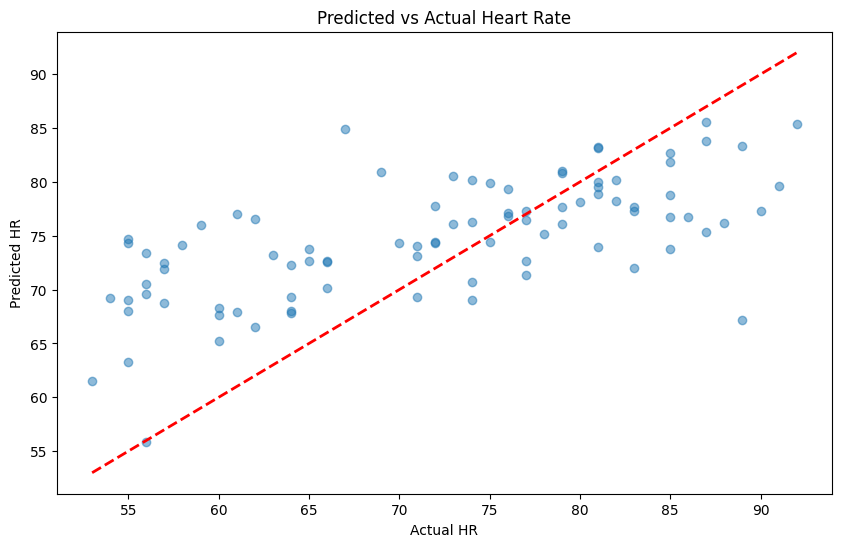

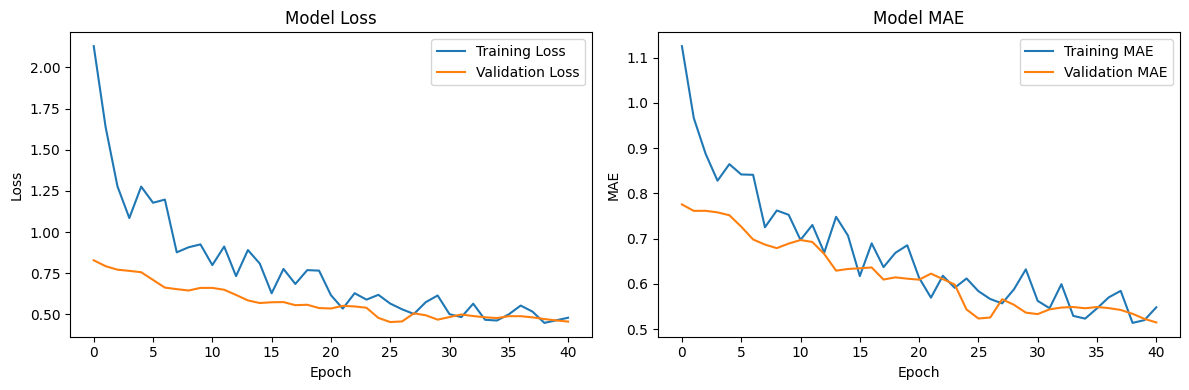

In [574]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2)
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Predicted vs Actual Heart Rate')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

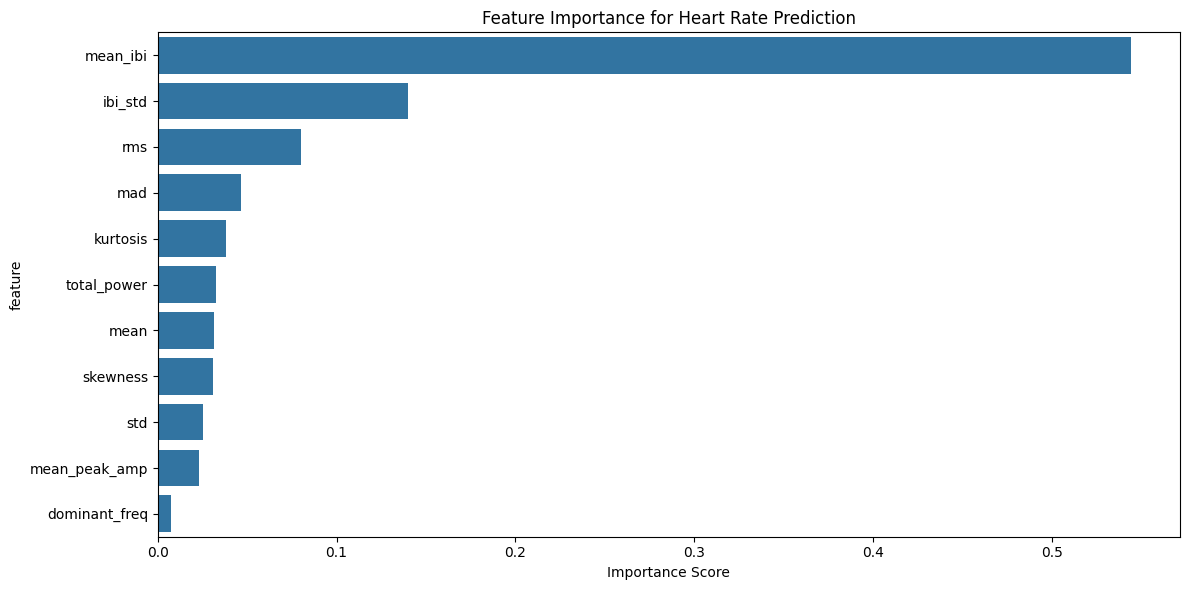


Top 5 most important features:
    feature  importance
8  mean_ibi    0.544589
9   ibi_std    0.139922
4       rms    0.080381
5       mad    0.046311
3  kurtosis    0.038330


In [575]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Random Forest model to analyze feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on engineered features only
X = prepared_data['engineered_features']
y = prepared_data['targets']

rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': [col for col in df_features.columns if col != 'HR'],
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Heart Rate Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

In [576]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import GlobalAveragePooling1D

def create_modified_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers with residual connections
    x = Conv1D(32, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    conv1 = x
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # Add residual connection
    x_upsampled = tf.keras.layers.UpSampling1D(4)(x)
    x = concatenate([conv1, x_upsampled])
    
    # LSTM with attention
    x = LSTM(64, return_sequences=True)(x)
    
    # Self-attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Softmax(axis=1)(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    x = GlobalAveragePooling1D()(x)
    
    # Engineered features input with weighted importance
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    
    # Process engineered features based on importance
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dense(16, activation='relu')(engineered_x)
    
    # Combine features with attention-based weighting
    combined = concatenate([x, engineered_x])
    
    # Final dense layers with skip connections
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    skip = x
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = concatenate([x, skip])
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create modified model
modified_model = create_modified_model(
    sequence_length=300,
    n_engineered_features=len(df_features.columns) - 1
)

# Compile model with fixed learning rate instead of schedule
modified_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Fixed initial learning rate
    loss='mse',
    metrics=['mae']
)

# Modified callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_modified.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train modified model
history_modified = modified_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate modified model
test_loss_modified = modified_model.evaluate(
    [test_data['ppg_signals'], test_data['engineered_features']],
    test_data['targets'],
    verbose=0
)

print(f"\nModified Model Test Results:")
print(f"Test loss: {test_loss_modified[0]:.4f}")
print(f"Test MAE: {test_loss_modified[1]:.4f}")

# Make predictions and calculate R²
test_predictions_modified = modified_model.predict(
    [test_data['ppg_signals'], test_data['engineered_features']]
)
test_predictions_original_modified = prepared_data['target_scaler'].inverse_transform(test_predictions_modified.reshape(-1, 1))
test_actual_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

r2_modified = r2_score(test_actual_original, test_predictions_original_modified)
print(f"Test R² score: {r2_modified:.4f}")

Epoch 1/100
9/9 [==============================] - 4s 247ms/step - loss: 2.2402 - mae: 1.1796 - val_loss: 0.9692 - val_mae: 0.8708 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 37ms/step - loss: 1.5847 - mae: 1.0210 - val_loss: 0.9553 - val_mae: 0.8629 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 36ms/step - loss: 1.3474 - mae: 0.9149 - val_loss: 0.9439 - val_mae: 0.8577 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 37ms/step - loss: 1.1292 - mae: 0.7923 - val_loss: 0.9345 - val_mae: 0.8548 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 37ms/step - loss: 1.1508 - mae: 0.8369 - val_loss: 0.9236 - val_mae: 0.8490 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 29ms/step - loss: 1.1249 - mae: 0.8033 - val_loss: 0.9252 - val_mae: 0.8503 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 36ms/step - loss: 0.9541 - mae: 0.7249 - val_loss: 0.9234 - val_mae: 0.8502 - lr: 0.001

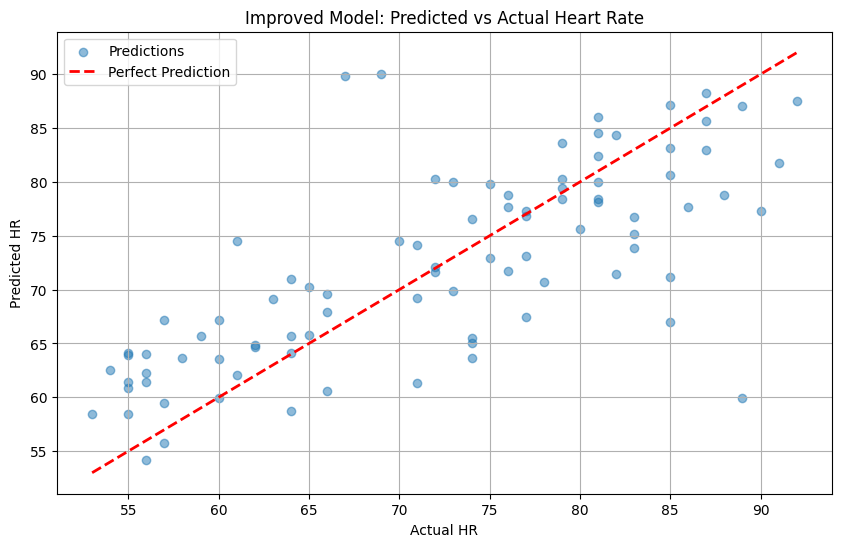

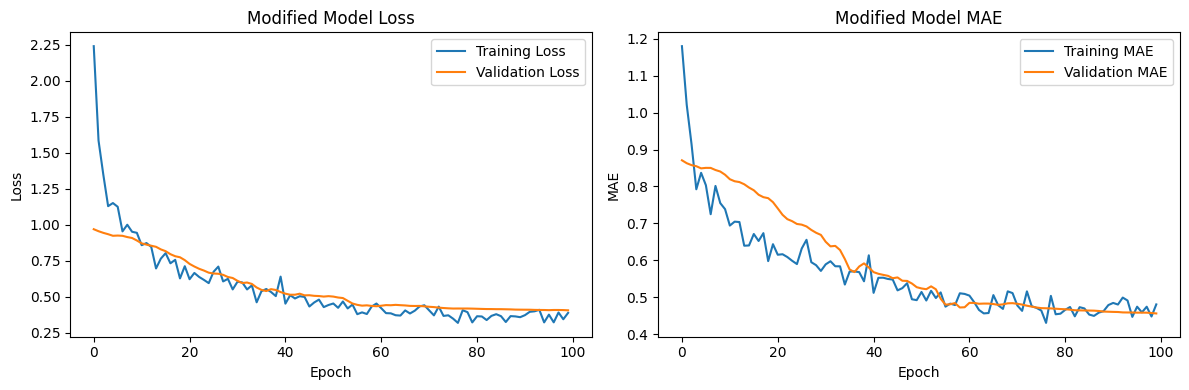

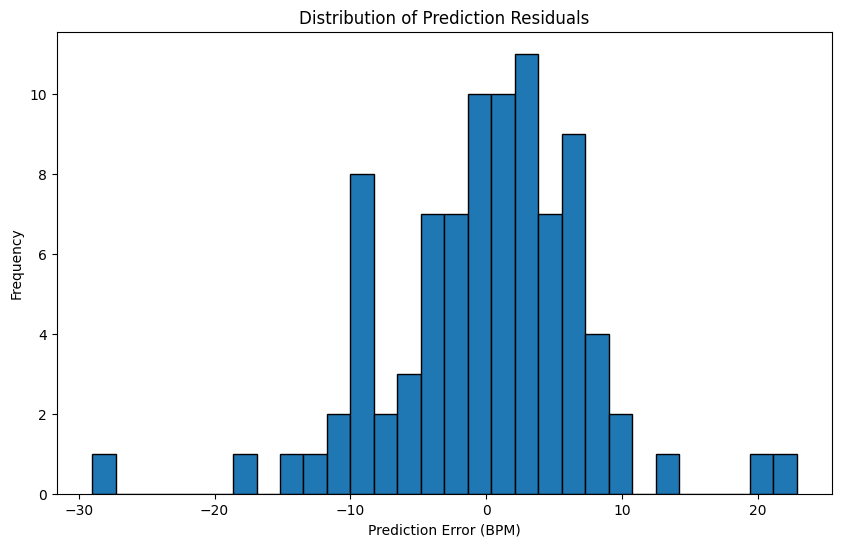


Detailed Error Metrics:
Root Mean Square Error (RMSE): 7.54 BPM
Mean Absolute Error (MAE): 5.59 BPM
Standard Deviation of Errors: 7.54 BPM


In [577]:
# Plot predictions vs actual values for improved model
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original_modified, alpha=0.5, label='Predictions')
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Improved Model: Predicted vs Actual Heart Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_modified.history['loss'], label='Training Loss')
plt.plot(history_modified.history['val_loss'], label='Validation Loss')
plt.title('Modified Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_modified.history['mae'], label='Training MAE')
plt.plot(history_modified.history['val_mae'], label='Validation MAE')
plt.title('Modified Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and visualize residuals
residuals = test_predictions_original_modified - test_actual_original
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Prediction Error (BPM)')
plt.ylabel('Frequency')
plt.show()

# Calculate additional error metrics
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
print("\nDetailed Error Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} BPM")
print(f"Mean Absolute Error (MAE): {mae:.2f} BPM")
print(f"Standard Deviation of Errors: {np.std(residuals):.2f} BPM")

In [578]:
# Modify sample weights to focus more on extreme ranges
def create_range_weights(y):
    weights = np.ones_like(y)
    # More weight to extreme ranges
    weights[y < 60] = 2.0  # Low HR
    weights[y > 85] = 2.0  # High HR
    return weights

In [579]:
def range_aware_loss(y_true, y_pred):
    base_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Additional penalty for errors in extreme ranges
    high_range_mask = tf.cast(y_true > 85, tf.float32)
    low_range_mask = tf.cast(y_true < 60, tf.float32)
    range_penalty = tf.abs(y_true - y_pred) * (high_range_mask + low_range_mask)
    return base_loss + 0.5 * tf.reduce_mean(range_penalty)

In [580]:
# Modify the loss function to penalize larger errors more heavily
def custom_loss(y_true, y_pred):
    # Base MSE loss
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Additional penalty for large errors (asymmetric to handle the skew)
    large_error_penalty = tf.where(
        tf.abs(y_true - y_pred) > 0.5,  # threshold in standardized scale
        tf.square(tf.abs(y_true - y_pred) - 0.5),
        0.0
    )
    return mse + 0.1 * large_error_penalty

# Create model with the same architecture but modified training
def create_balanced_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers (same as before)
    x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM layers with gradient clipping to prevent extreme predictions
    x = LSTM(100, return_sequences=True, 
             kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    x = LSTM(50, kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    
    # Combine features
    combined = concatenate([x, engineered_x])
    
    # Final dense layers with additional regularization
    x = Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Output with activation to bound predictions
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Modified callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_balanced.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Create and compile model
balanced_model = create_balanced_model(
    sequence_length=300,
    n_engineered_features=train_data['engineered_features'].shape[1]
)

# Compile with custom loss
balanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=custom_loss,
    metrics=['mae']
)

# Create balanced sample weights
def create_balanced_weights(y):
    errors = np.abs(y - np.mean(y))
    weights = np.ones_like(y)
    # Give more weight to samples far from mean
    weights[errors > np.std(y)] = 1.2
    # Give even more weight to extreme cases
    weights[errors > 2*np.std(y)] = 1.5
    return weights

# Train with balanced weights
train_weights = create_balanced_weights(train_data['targets'])

history = balanced_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    sample_weight=train_weights,
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 4s 110ms/step - loss: 2.5967 - mae: 1.1358 - val_loss: 1.0017 - val_mae: 0.8467 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 1.6425 - mae: 0.8969 - val_loss: 0.9104 - val_mae: 0.8029 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 1.2073 - mae: 0.7901 - val_loss: 0.9014 - val_mae: 0.7831 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 1.0196 - mae: 0.7469 - val_loss: 0.9190 - val_mae: 0.8128 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 28ms/step - loss: 1.3945 - mae: 0.8596 - val_loss: 0.8815 - val_mae: 0.7909 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 27ms/step - loss: 1.0822 - mae: 0.7380 - val_loss: 0.8670 - val_mae: 0.7711 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 19ms/step - loss: 1.0825 - mae: 0.7758 - val_loss: 0.9047 - val_mae: 0.8040 - lr: 0.001

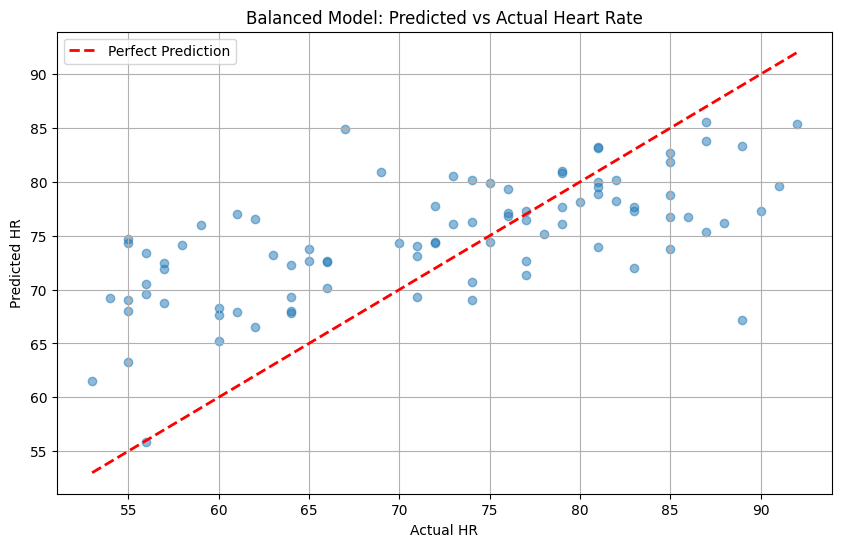

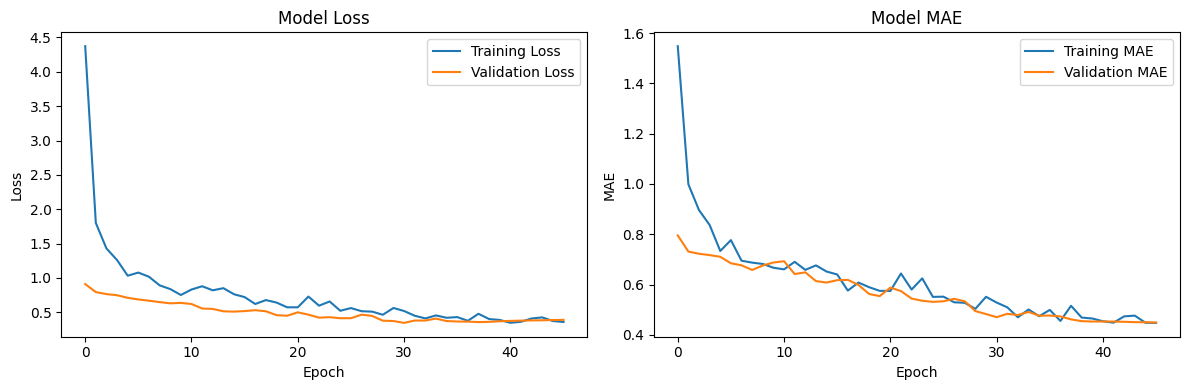

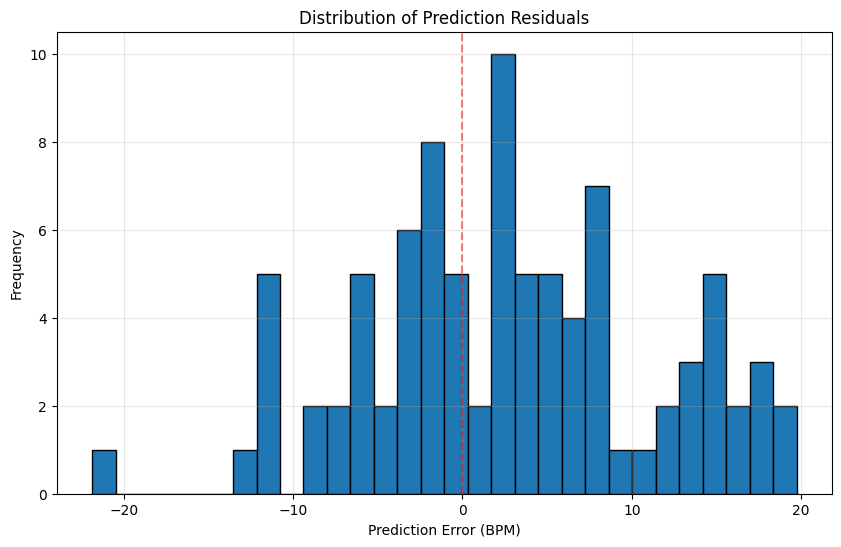


Detailed Error Metrics:
R² Score: 0.3485
Root Mean Square Error (RMSE): 8.90 BPM
Mean Absolute Error (MAE): 7.09 BPM
Standard Deviation of Errors: 8.48 BPM

MAE by HR Range:
HR 50-60: MAE = 13.69 BPM (n=16)
HR 60-70: MAE = 8.34 BPM (n=19)
HR 70-80: MAE = 3.02 BPM (n=27)
HR 80-90: MAE = 5.89 BPM (n=24)
HR 90-100: MAE = 10.23 BPM (n=3)


In [584]:
# 1. Predictions vs Actual values scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Balanced Model: Predicted vs Actual Heart Rate')
plt.legend()
plt.grid(True)
plt.show()

# 2. Training history plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Error distribution
residuals = (test_predictions_original - test_actual_original).flatten()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Prediction Error (BPM)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Print detailed metrics
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
r2 = r2_score(test_actual_original, test_predictions_original)

print("\nDetailed Error Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} BPM")
print(f"Mean Absolute Error (MAE): {mae:.2f} BPM")
print(f"Standard Deviation of Errors: {np.std(residuals):.2f} BPM")

# 5. Error by HR range
df_results = pd.DataFrame({
    'Actual': test_actual_original.flatten(),
    'Predicted': test_predictions_original.flatten(),
    'Error': np.abs(test_predictions_original.flatten() - test_actual_original.flatten())
})

hr_ranges = [(50,60), (60,70), (70,80), (80,90), (90,100)]
print("\nMAE by HR Range:")
for low, high in hr_ranges:
    mask = (df_results['Actual'] >= low) & (df_results['Actual'] < high)
    range_mae = df_results.loc[mask, 'Error'].mean()
    range_count = mask.sum()
    print(f"HR {low}-{high}: MAE = {range_mae:.2f} BPM (n={range_count})")

In [583]:
def create_refined_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers (keeping the effective structure from best model)
    x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM layers with careful regularization
    x = LSTM(100, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dropout(0.2)(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    
    # Combine features
    combined = concatenate([x, engineered_x])
    
    # Final dense layers
    x = Dense(64, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create and compile model
refined_model = create_refined_model(
    sequence_length=300,
    n_engineered_features=train_data['engineered_features'].shape[1]
)

# Compile with standard loss but clip gradients
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0  # Gradient clipping
)

refined_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Simple class weights focusing on extremes
def create_simple_weights(y):
    weights = np.ones_like(y)
    # Slight emphasis on extreme values
    weights[y < 60] = 1.1
    weights[y > 85] = 1.1
    return weights

train_weights = create_simple_weights(train_data['targets'])

# Train with original callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_refined.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train model
history = refined_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    sample_weight=train_weights,
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 4s 109ms/step - loss: 4.3730 - mae: 1.5479 - val_loss: 0.9115 - val_mae: 0.7955 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 32ms/step - loss: 1.8010 - mae: 0.9987 - val_loss: 0.7949 - val_mae: 0.7313 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 38ms/step - loss: 1.4297 - mae: 0.8961 - val_loss: 0.7658 - val_mae: 0.7226 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 33ms/step - loss: 1.2607 - mae: 0.8370 - val_loss: 0.7492 - val_mae: 0.7173 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 34ms/step - loss: 1.0332 - mae: 0.7338 - val_loss: 0.7117 - val_mae: 0.7107 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 33ms/step - loss: 1.0789 - mae: 0.7769 - val_loss: 0.6881 - val_mae: 0.6849 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 35ms/step - loss: 1.0179 - mae: 0.6950 - val_loss: 0.6695 - val_mae: 0.6767 - lr: 0.001

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, Dense, BatchNormalization, 
    MaxPooling1D, Dropout, concatenate, GlobalAveragePooling1D,
    LeakyReLU
)

class PPGModel:
    def __init__(
        self,
        sequence_length=300,
        n_features=1,
        n_engineered_features=24,  # Number of engineered features
        target_name='HR'  # Can be 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic'
    ):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.n_engineered_features = n_engineered_features
        self.target_name = target_name
        self.model = self._build_model()
        
    def _build_model(self):
        # Input layers
        ppg_input = Input(shape=(self.sequence_length, self.n_features), name='ppg_input')
        engineered_features_input = Input(shape=(self.n_engineered_features,), name='engineered_features_input')
        
        # CNN branch for raw PPG signal
        x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = MaxPooling1D(2)(x)
        
        x = Conv1D(128, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = MaxPooling1D(2)(x)
        
        # LSTM layers
        x = LSTM(100, return_sequences=True)(x)
        x = Dropout(0.2)(x)
        x = LSTM(50)(x)
        x = Dropout(0.2)(x)
        
        # Process engineered features
        engineered_x = Dense(32, activation='relu')(engineered_features_input)
        engineered_x = BatchNormalization()(engineered_x)
        engineered_x = Dropout(0.2)(engineered_x)
        
        # Combine CNN-LSTM branch with engineered features
        combined = concatenate([x, engineered_x])
        
        # Final dense layers
        x = Dense(64, activation='relu')(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        output = Dense(1, name=f'{self.target_name}_output')(x)
        
        model = Model(
            inputs=[ppg_input, engineered_features_input],
            outputs=output
        )
        
        return model
    
    def compile_model(self, learning_rate=0.001):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae', 'mse', self._r2_score]
        )
    
    def _r2_score(self, y_true, y_pred):
        SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
        SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())
    
    def train(
        self,
        ppg_signals,
        engineered_features,
        targets,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        early_stopping_patience=15
    ):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=early_stopping_patience,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            tf.keras.callbacks.ModelCheckpoint(
                f'best_model_{self.target_name}.h5',
                monitor='val_loss',
                save_best_only=True
            )
        ]
        
        history = self.model.fit(
            [ppg_signals, engineered_features],
            targets,
            validation_split=validation_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        
        return history

# Usage example:
"""
# 1. Prepare your data
# Assuming you have:
# - normalized_ppg_signals: shape (n_samples, 300, 1)
# - engineered_features: shape (n_samples, n_engineered_features)
# - targets: shape (n_samples,)

# 2. Create and train model for heart rate prediction
hr_model = PPGModel(
    sequence_length=300,
    n_features=1,
    n_engineered_features=24,  # Adjust based on your features
    target_name='HR'
)

# 3. Compile model
hr_model.compile_model(learning_rate=0.001)

# 4. Train model
history = hr_model.train(
    ppg_signals=normalized_ppg_signals,
    engineered_features=engineered_features,
    targets=hr_targets,
    batch_size=32,
    epochs=100
)
"""

In [467]:
# Load your dataset
df = pd.read_csv("transformed_ppg_data.csv")

# Preprocess the data
df_processed, scaler = preprocess_data(df)

# Extract features
feature_list = []
for _, row in df_processed.iterrows():
    features = extract_features(row["PPG_SIGNAL_NORMALIZED"])
    feature_list.append(features)

# Convert features into a DataFrame
features_df = pd.DataFrame(feature_list)

# Add the target columns back (e.g., HR, SpO2, Glycaemia, Systolic, Diastolic)
features_df["HR"] = df_processed["HR"]
features_df["SpO2"] = df_processed["SpO2"]
features_df["Glycaemia"] = df_processed["Glycaemia"]
features_df["Systolic"] = df_processed["Systolic"]
features_df["Diastolic"] = df_processed["Diastolic"]

# Split into training, validation, and test sets
X = features_df.drop(columns=["HR", "SpO2", "Glycaemia", "Systolic", "Diastolic"])
y = features_df["HR"]  # Use other targets for other predictions
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [468]:
# Prepare inputs for the CNN-LSTM model
X_train_model = prepare_model_inputs(df_processed.iloc[X_train.index])
X_val_model = prepare_model_inputs(df_processed.iloc[X_val.index])
X_test_model = prepare_model_inputs(df_processed.iloc[X_test.index])


In [473]:
# Create the model
model = create_model(input_shape=(X.shape[1], 1))
callbacks = prepare_training(model)

# Display model summary
model.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 7, 64)             384       
                                                                 
 batch_normalization_18 (Bat  (None, 7, 64)            256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 64)             0         
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 batch_normalization_19 (Bat  (None, 3, 128)         

In [474]:
# Train the model
history = model.fit(
    X_train_model, y_train,
    validation_data=(X_val_model, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100


ValueError: in user code:

    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_32" is incompatible with the layer: expected shape=(None, 7, 1), found shape=(None, 300, 1)


In [ ]:
# Evaluate the model
test_loss, test_mae, test_mse = model.evaluate(X_test_model, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")


3/3 [==============================] - 0s 7ms/step - loss: 0.0370 - mae: 0.1664 - mse: 0.0370
Test Loss: 0.03704243525862694, Test MAE: 0.16638098657131195, Test MSE: 0.03704243525862694


3/3 [==============================] - 1s 13ms/step


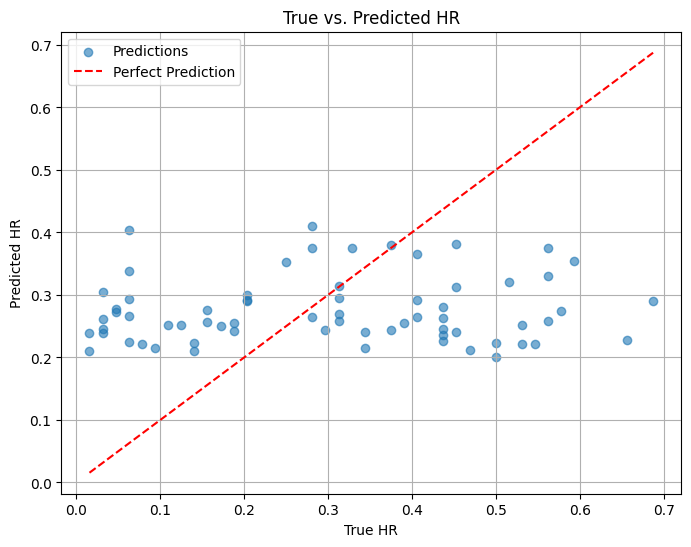

In [ ]:
# Make predictions
y_pred = model.predict(X_test_model)

# Plot true vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs. Predicted HR")
plt.legend()
plt.grid()
plt.show()


In [426]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis

# Function to extract features from a PPG signal
def extract_features(ppg_signal, fs=30):
    """
    Extracts features from a single PPG signal.
    
    Parameters:
        ppg_signal (list): List of PPG signal values.
        fs (int): Sampling frequency (Hz).
    
    Returns:
        dict: Extracted features.
    """
    # Convert signal to numpy array
    signal = np.array(ppg_signal)
    
    # Time-domain features
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    rms = np.sqrt(np.mean(signal ** 2))
    mad = np.mean(np.abs(signal - mean_val))
    
    # Frequency-domain features
    freqs, psd = welch(signal, fs=fs, nperseg=len(signal))
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    
    # Beat-to-beat features
    peaks, _ = find_peaks(signal, distance=fs * 0.5)  # Assuming beats are >0.5s apart
    ibi = np.diff(peaks) / fs  # Convert to seconds
    mean_ibi = np.mean(ibi) if len(ibi) > 0 else 0
    ibi_std = np.std(ibi) if len(ibi) > 0 else 0
    peak_amplitudes = signal[peaks]
    mean_peak_amp = np.mean(peak_amplitudes) if len(peak_amplitudes) > 0 else 0
    
    # Collect all features
    features = {
        "mean": mean_val,
        "std": std_val,
        "skewness": skewness,
        "kurtosis": kurt,
        "rms": rms,
        "mad": mad,
        "dominant_freq": dominant_freq,
        "total_power": total_power,
        "mean_ibi": mean_ibi,
        "ibi_std": ibi_std,
        "mean_peak_amp": mean_peak_amp,
    }
    
    return features

# Load the transformed dataset
ppg_grouped = pd.read_csv("transformed_ppg_data.csv")

# Extract features for each row and add them to the dataframe
features_list = []
for _, row in ppg_grouped.iterrows():
    signal_features = extract_features(eval(row["PPG_SIGNAL"]))
    signal_features["HR"] = row["HR"]  # Include the HR as target
    features_list.append(signal_features)

# Convert to a DataFrame
df_features = pd.DataFrame(features_list)

# Save the final DataFrame with features
df_features.to_csv("ppg_features_with_hr.csv", index=False)

print("Features extracted and saved to 'ppg_features_with_hr.csv'")


Features extracted and saved to 'ppg_features_with_hr.csv'


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Split data into features and target
X = df_features.drop(columns=["HR"])
y = df_features["HR"]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set up the model and parameter grid
model = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_absolute_error", verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate on validation set
val_predictions = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
print(f"Validation MAE: {val_mae:.2f}, R²: {val_r2:.2f}")

# Final testing
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Validation MAE: 4.51, R²: 0.55
Test MAE: 5.18, R²: 0.59


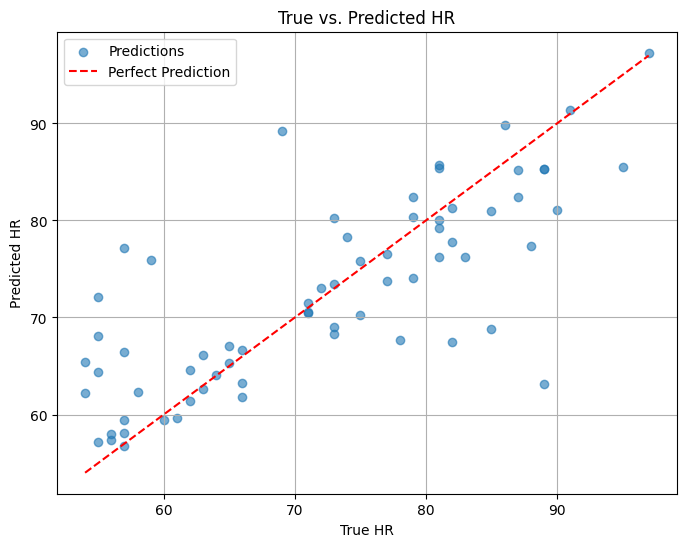

In [428]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs. Predicted HR")
plt.legend()
plt.grid(True)
plt.show()


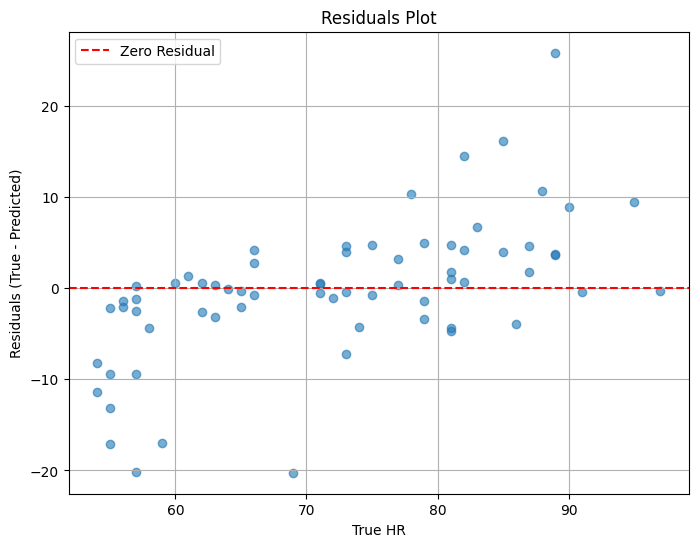

In [429]:
residuals = y_test - test_predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", label="Zero Residual")
plt.xlabel("True HR")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.show()


Feature Importance:
          Feature  Importance
8        mean_ibi    0.609831
9         ibi_std    0.143630
4             rms    0.054591
2        skewness    0.035643
3        kurtosis    0.032715
0            mean    0.031128
7     total_power    0.029112
5             mad    0.023137
10  mean_peak_amp    0.017987
1             std    0.017208
6   dominant_freq    0.005018


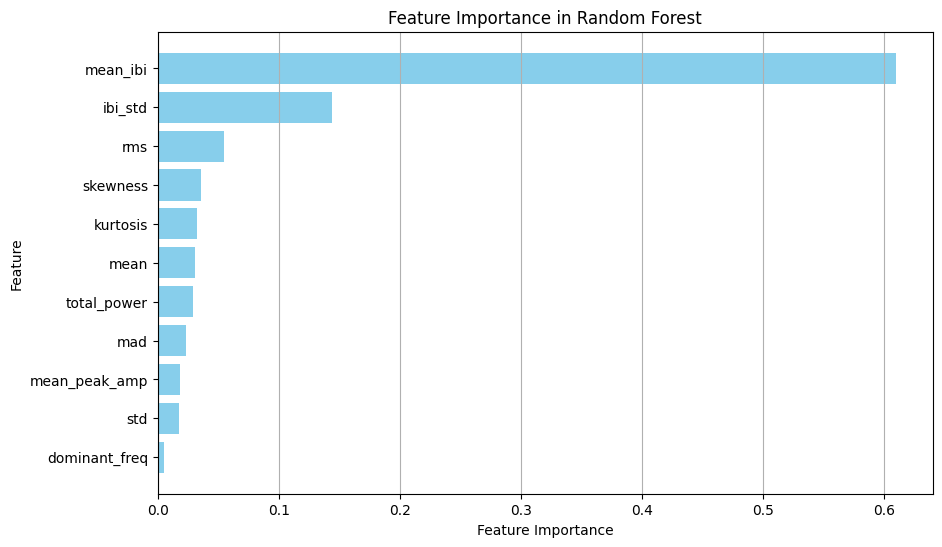

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the trained Random Forest model
feature_importance = best_model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Display the feature importance DataFrame
print("Feature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.grid(axis="x")
plt.show()


In [431]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load the feature dataset
df_features = pd.read_csv("ppg_features_with_hr.csv")

# Separate features and target variable
X = df_features.drop(columns=["HR"])
y = df_features["HR"]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validate the model
val_predictions = model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MAE: {val_mae:.2f}, R²: {val_r2:.2f}")

# Test the model
test_predictions = model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")


Validation MAE: 4.58, R²: 0.55
Test MAE: 5.32, R²: 0.57


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Validation MAE: 4.53, R²: 0.53
Test MAE: 5.11, R²: 0.61


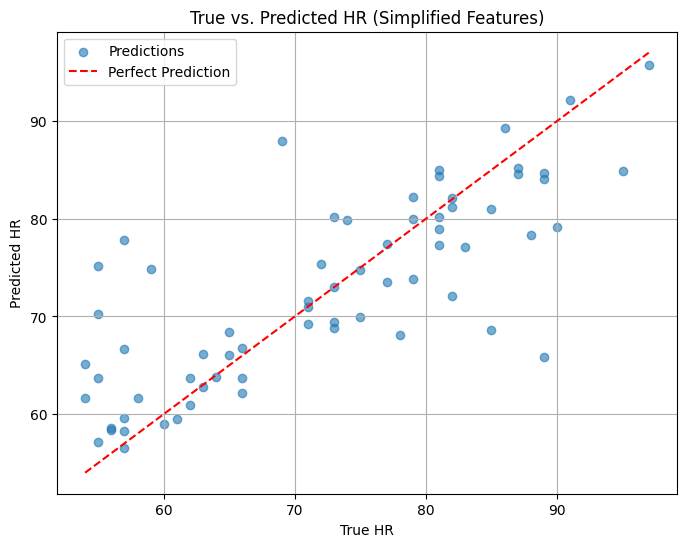

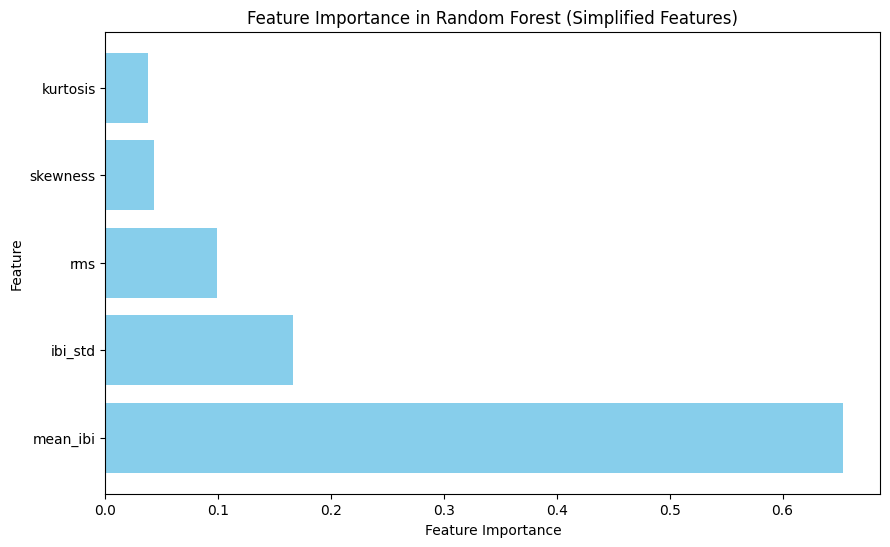

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature dataset
df_features = pd.read_csv("ppg_features_with_hr.csv")

# Simplify feature set: Retain only top features
top_features = ["mean_ibi", "ibi_std", "rms", "skewness", "kurtosis", "HR"]
df_top_features = df_features[top_features]

# Split data into features and target
X = df_top_features.drop(columns=["HR"])
y = df_top_features["HR"]

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the Random Forest model and parameter grid
model = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_absolute_error", verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Validate the model
val_predictions = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
print(f"Validation MAE: {val_mae:.2f}, R²: {val_r2:.2f}")

# Test the model
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")

# Plot True vs Predicted for Test Set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs. Predicted HR (Simplified Features)")
plt.legend()
plt.grid()
plt.show()

# Plot feature importance
feature_importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest (Simplified Features)")
plt.show()


Validation MAE: 5.00, R²: 0.47
Test MAE: 5.11, R²: 0.61


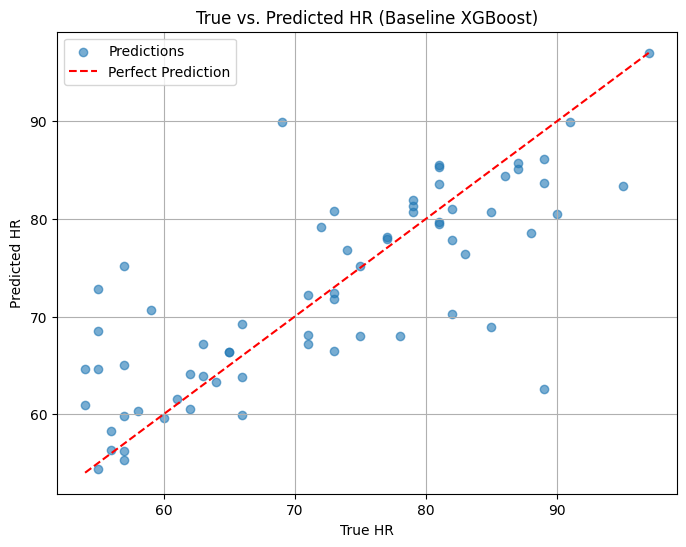

In [433]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load your data
df_features = pd.read_csv("ppg_features_with_hr.csv")

# Simplify feature set
top_features = ["mean_ibi", "ibi_std", "rms", "skewness", "kurtosis", "HR"]
df_top_features = df_features[top_features]

# Split data
X = df_top_features.drop(columns=["HR"])
y = df_top_features["HR"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize model with baseline hyperparameters
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=3,  # Prevents overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


# Train the model
model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
print(f"Validation MAE: {val_mae:.2f}, R²: {val_r2:.2f}")

# Evaluate on test set
test_predictions = model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")

# Plot True vs. Predicted HR
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs. Predicted HR (Baseline XGBoost)")
plt.legend()
plt.grid()
plt.show()


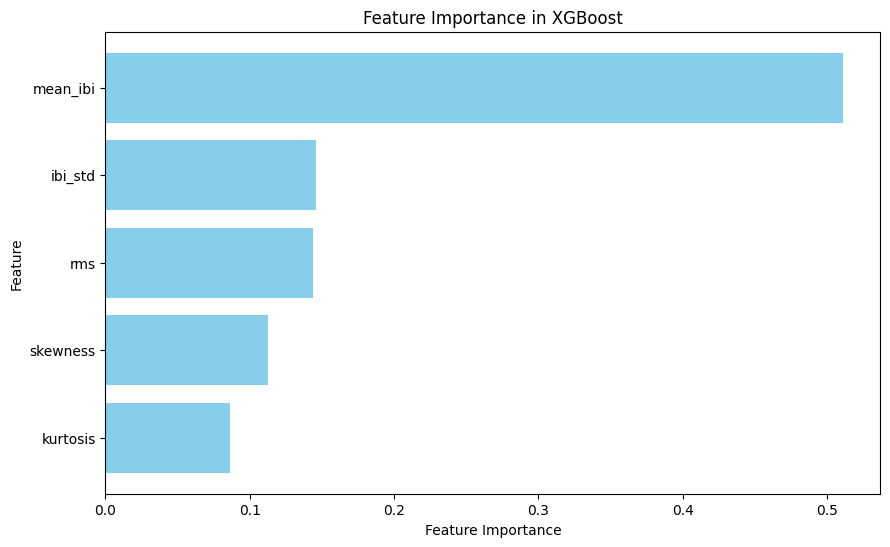

In [434]:
# Plot feature importance
import numpy as np

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost")
plt.show()


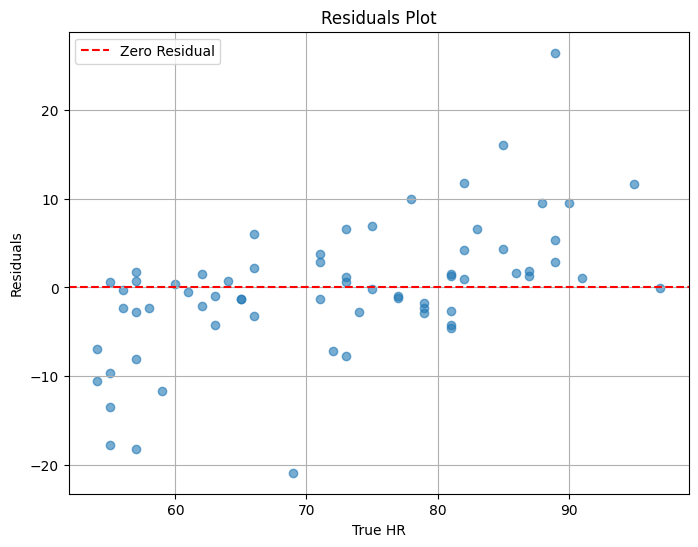

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - test_predictions

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', label="Zero Residual")
plt.xlabel("True HR")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid()
plt.show()
